In [406]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()

import pyspark
from pyspark.sql import *
import pyspark.sql.functions as func
from pyspark.sql.types import *

import seaborn as sns
from matplotlib.colors import ListedColormap

%run insights.py
%run plot.py

In [2]:
spark = SparkSession.builder.getOrCreate()

In [275]:
# Load all datasets
metrics = spark.read.load('../data/dataset_metrics.parquet').toPandas()
score_metrics = spark.read.load('../data/score_metrics.parquet').toPandas().set_index('score')
comments = spark.read.load('../data/sample.parquet')
comments.registerTempTable("comments")
daily_metrics = spark.read.load('../data/daily_metrics.parquet').toPandas().set_index('created')
subreddit_agreement = spark.read.load('../data/subreddit_agreement.parquet').toPandas().set_index('subreddit')
daily_agreement = spark.read.load('../data/daily_agreement.parquet').toPandas().set_index('created')
lda_result_one_w_df = spark.read.load('../data/oneW_oneT_lda_result.parquet').toPandas().set_index('post_id')
lda_result_three_w_df = spark.read.load('../data/threeW_twoT_lda_result.parquet').toPandas().set_index('post_id')
nlp = spark.read.load('../data/subreddit_nlp_full_0.001.parquet')
nlp.registerTempTable("nlp")
nlp_per_community = spark.read.load('../data/nlp_per_community.parquet')
agreement_per_community = spark.read.load('../data/agreement_per_community.parquet').toPandas().set_index('Group')
agreement_per_subgroup = spark.read.load('../data/agreement_per_subgroup.parquet').toPandas().set_index('Subgroup')

In [382]:
def fetch_metric_for_group(metric, group):    
    return spark.sql("""
        SELECT {}
        FROM nlp JOIN subreddits ON LOWER(nlp.subreddit) == subreddits.subreddit
        WHERE subreddits.Group == '{}'
    """.format(metric, group)).toPandas()

def fetch_metric_for_subgroup(metric, subgroup):    
    return spark.sql("""
        SELECT {}
        FROM nlp JOIN subreddits ON LOWER(nlp.subreddit) == subreddits.subreddit
        WHERE subreddits.Subgroup == '{}'
    """.format(metric, subgroup)).toPandas()

def create_group_metrics(groups, metrics):
    return { metric: [ fetch_metric_for_group(metric, group) for group in groups ] for metric in metrics }

def create_subgroup_metrics(subgroups, metrics):
    return { metric: [ fetch_metric_for_subgroup(metric, subgroup) for subgroup in subgroups ] for metric in metrics }

In [337]:
def load_subreddit_list(name, subgroup=None):

    with open('../data/subreddits/' + name + '.txt') as f:
        lines = f.readlines()

    group = ""
    subreddit_list_df = pd.DataFrame(data=[], columns=['type'])

    for line in lines:

        if line == '\n':
            continue

        if line[0] == '#':
            group = line[2:].strip('\n')
            continue
            
        if subgroup != None and group not in subgroup:
            continue

        subreddit = line[3:].strip('\n').lower()

        subreddit_list_df.loc[subreddit] = group
    
    return subreddit_list_df

## A Look at Reddit Communities

Now that we have a pretty good idea of how we can measure divisiveness, negativity and vulgarity, it is interesting to take a deeper dive into specific communities and sub-communities and see how these metrics compare. 

In order to do that, we initially compiled a list of communities related to a specific topic. This was done with the help of [/r/ListOfSubreddits](https://www.reddit.com/r/ListOfSubreddits/wiki/listofsubreddits) which provides an extensive list of active communities organized by topic. 

### Macro-Analysis of General Communities

First of all, we decided to extract 4 "macro communities" based on types of discussion. These

* **Politics**, which contains all subreddits linked to discussions about politics, political ideologies, political news, political candidates and so forth.
* **Sports**, another big group of commmunities linked to discussions on sports in general, a specific sport or a specific sports team.
* **Music**, related to genres of music, specific bands or general discussions on music
* **Video Games**, related to video games in general, to a subgenre of games, a specific game, game company or console.

First, we will analyze how the negativity and positivity metrics we computed earlier vary depending on the macro-communities chosen.

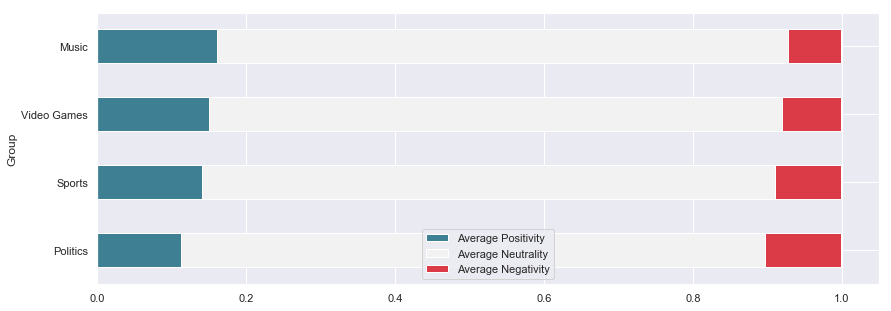

In [139]:
# Using Spark, get the mean positivity, negativity, neutrality, etc... for each "Group" (= macro-community)
nlp_per_community_group_avg_df = nlp_per_community.groupBy(func.col('Group')).mean().toPandas().set_index('Group').rename(columns={
    'avg(Negativity)': 'Average Negativity', 
    'avg(Positivity)': 'Average Positivity', 
    'avg(Neutrality)': 'Average Neutrality',
    'avg(Vulgarity)': 'Average Vulgarity'
})

# Plot the neutrality, positivity and negativity of each Group
_ = nlp_per_community_group_avg_df[['Average Positivity', 'Average Neutrality','Average Negativity']].sort_values('Average Positivity').plot(
    kind='barh', 
    stacked=True, 
    colormap=ListedColormap(sns.diverging_palette(220, 10, sep=80, n=3)), 
    figsize=(14,5)
)

From the chart above, we can see that, even though most of the discussion is neutral, Politics is simultaneously the most negative and least positive type of discussion. Let's look at it this by also looking

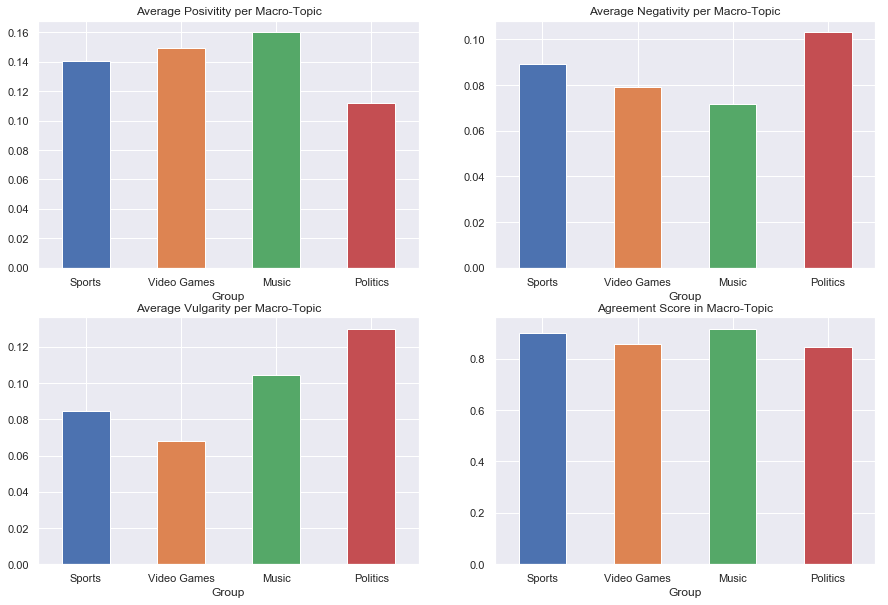

In [274]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10), , constrained_layout=True)

axes[0, 0].set_title("Average Posivitity per Macro-Topic")
axes[0, 1].set_title("Average Negativity per Macro-Topic")
axes[1, 0].set_title("Average Vulgarity per Macro-Topic")
axes[1, 1].set_title("Agreement Score in Macro-Topic")

_ = nlp_per_community_group_avg_df['Average Positivity'].plot(
    kind='bar', ax=axes[0, 0], rot=0
)

_ = nlp_per_community_group_avg_df['Average Negativity'].plot(
    kind='bar', ax=axes[0, 1], rot=0
)

_ = nlp_per_community_group_avg_df['Average Vulgarity'].plot(
    kind='bar', ax=axes[1, 0], rot=0
)

_ = agreement_per_community['agreement_factor'].reindex(nlp_per_community_group_avg_df.index).plot(
    kind='bar', ax=axes[1, 1], rot=0
)

TEXT

In [325]:
groups = ['Politics', 'Sports', 'Music', 'Video Games']
metrics = ['nltk_negativity', 'nltk_positivity']

In [326]:
# Fetch all comments and their metric for each group (warning: expensive computation)
group_metrics = create_group_metrics(groups=groups, metrics=metrics) 

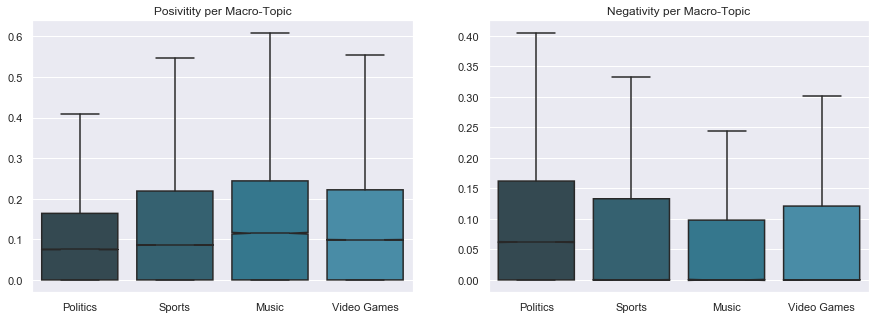

In [381]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].set_title("Posivitity per Macro-Topic")
axes[1].set_title("Negativity per Macro-Topic")

sns.boxplot(data=group_metrics['nltk_positivity'], ax=axes[0], showfliers=False, notch=True)
sns.boxplot(data=group_metrics['nltk_negativity'], ax=axes[1], showfliers=False, notch=True)

axes[0].set_xticklabels(groups)
_ = axes[1].set_xticklabels(groups)

### Deeper Dive into Political Communities

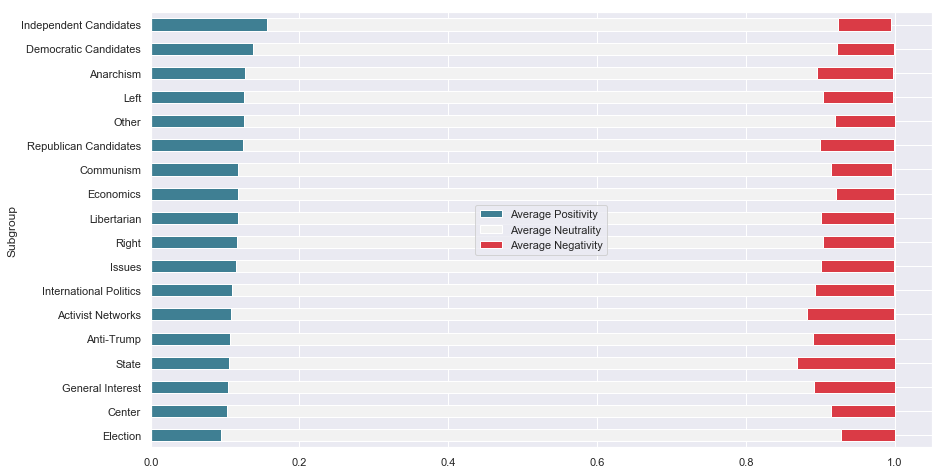

In [290]:
# Using Spark, get the mean positivity, negativity, neutrality, etc... for each "Group" (= macro-community)
nlp_per_community_subgroup_avg_df = nlp_per_community.filter(func.col('Group') == func.lit('Politics')).groupBy(func.col('Subgroup')).mean().toPandas().set_index('Subgroup').rename(columns={
    'avg(Negativity)': 'Average Negativity', 
    'avg(Positivity)': 'Average Positivity', 
    'avg(Neutrality)': 'Average Neutrality',
    'avg(Vulgarity)': 'Average Vulgarity'
})

# Plot the neutrality, positivity and negativity of each Group
_ = nlp_per_community_subgroup_avg_df[['Average Positivity', 'Average Neutrality','Average Negativity']].sort_values('Average Positivity').plot(
    kind='barh',
    stacked=True,
    colormap=ListedColormap(sns.diverging_palette(220, 10, sep=80, n=3)), 
    figsize=(14,8)
)

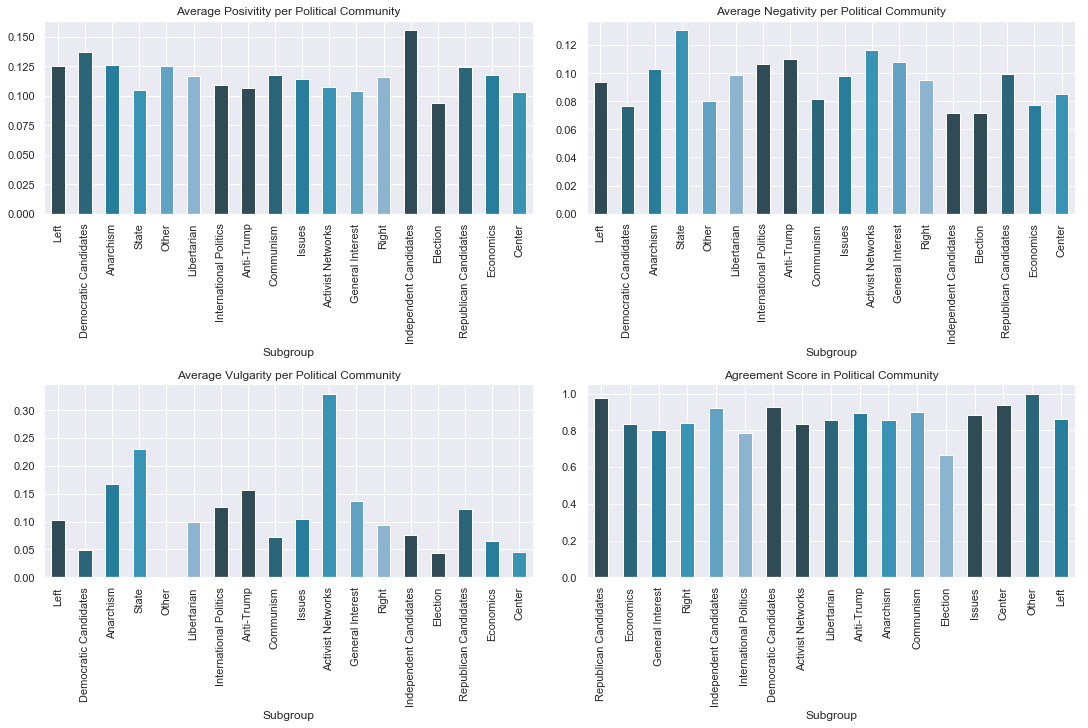

In [374]:

sns.set(palette="PuBuGn_d")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10), constrained_layout=True)

axes[0, 0].set_title("Average Posivitity per Political Community")
axes[0, 1].set_title("Average Negativity per Political Community")
axes[1, 0].set_title("Average Vulgarity per Political Community")
axes[1, 1].set_title("Agreement Score in Political Community")

_ = nlp_per_community_subgroup_avg_df['Average Positivity'].plot(
    kind='bar', ax=axes[0, 0], rot=90
)

_ = nlp_per_community_subgroup_avg_df['Average Negativity'].plot(
    kind='bar', ax=axes[0, 1], rot=90
)

_ = nlp_per_community_subgroup_avg_df['Average Vulgarity'].plot(
    kind='bar', ax=axes[1, 0], rot=90
)

_ = agreement_per_subgroup['agreement_factor'].reindex(agreement_per_subgroup.index).plot(
    kind='bar', ax=axes[1, 1], rot=90
)

In [332]:
subgroups = ['Independent Candidates', 'Democratic Candidates', 'Anarchism', 'Left', 'Republican Candidates',
            'Communism', 'Libertarian', 'Right', 'International Politics', 'Activist Networks',
          'Anti-Trump', 'Center']
metrics = ['nltk_negativity', 'nltk_positivity']

In [383]:
# Fetch all comments and their metric for each group (warning: expensive computation)
subgroup_metrics = create_subgroup_metrics(subgroups=subgroups, metrics=metrics) 

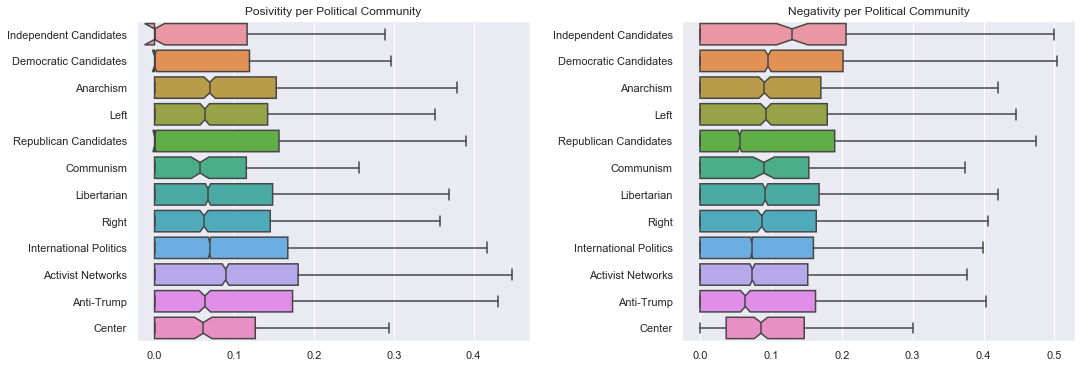

In [408]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), constrained_layout=True)

axes[0].set_title("Posivitity per Political Community")
axes[1].set_title("Negativity per Political Community")

sns.boxplot(data=subgroup_metrics['nltk_negativity'], ax=axes[0], showfliers=False, orient='h', notch=True)
sns.boxplot(data=subgroup_metrics['nltk_positivity'], ax=axes[1], showfliers=False, orient='h', notch=True)

axes[0].set_yticklabels(subgroups, rotation=0)
_ = axes[1].set_yticklabels(subgroups, rotation=0)